In [1]:
import sys

sys.path.append("./../../src")


from Dataset_mfcc import SpeechCommandsDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torchaudio.transforms as T


from helper import evaluate, get_all_preds, plot_loss_and_accuracy
from Transformer import plot_confusion_matrix


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
spec_augment = torch.nn.Sequential(
    T.FrequencyMasking(freq_mask_param=15), T.TimeMasking(time_mask_param=35)
)


test_dataset = SpeechCommandsDataset("./../../data/test", mode="modified")
train_dataset = SpeechCommandsDataset(
    "./../../data/train",
    mode="modified",
    transform=spec_augment,
)

In [3]:
class SpeechCommandCRNN(nn.Module):
    def __init__(self, num_classes=35):
        super(SpeechCommandCRNN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.gru_input_size = 128 * (40 // 1)  # 40 is number of MFCC bins

        self.gru = nn.GRU(
            input_size=self.gru_input_size,
            hidden_size=256,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
        )

        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(256 * 2, num_classes)

    def forward(self, x):
        x = self.conv(x)  # (batch, channels, freq, time)
        b, c, f, t = x.shape
        x = x.permute(0, 3, 1, 2)  # (batch, time, channels, freq)
        x = x.reshape(b, t, c * f)  # (batch, time, features)

        out, _ = self.gru(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [4]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
    persistent_workers=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=12,
    pin_memory=True,
    persistent_workers=True,
)

model = SpeechCommandCRNN(num_classes=12).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

num_epochs = 20

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for waveforms, labels in train_loader:
        waveforms, labels = waveforms.to(device), labels.to(device)

        outputs = model(waveforms)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    # Evaluate on test set
    test_acc, test_loss = evaluate(model, test_loader, device, silent=True)
    test_accuracies.append(test_acc)
    test_losses.append(test_loss)

    scheduler.step()

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2%} | Test Acc: {test_acc:.2%}")

Epoch 1 | Train Acc: 71.97% | Test Acc: 86.77%
Epoch 2 | Train Acc: 82.70% | Test Acc: 92.43%
Epoch 3 | Train Acc: 85.54% | Test Acc: 93.73%
Epoch 4 | Train Acc: 86.77% | Test Acc: 94.57%
Epoch 5 | Train Acc: 87.91% | Test Acc: 95.18%
Epoch 6 | Train Acc: 88.62% | Test Acc: 95.28%
Epoch 7 | Train Acc: 89.30% | Test Acc: 95.76%
Epoch 8 | Train Acc: 89.74% | Test Acc: 95.52%
Epoch 9 | Train Acc: 90.68% | Test Acc: 95.86%
Epoch 10 | Train Acc: 91.06% | Test Acc: 96.70%
Epoch 11 | Train Acc: 91.31% | Test Acc: 96.77%
Epoch 12 | Train Acc: 91.81% | Test Acc: 96.83%
Epoch 13 | Train Acc: 92.48% | Test Acc: 97.06%
Epoch 14 | Train Acc: 92.75% | Test Acc: 97.17%
Epoch 15 | Train Acc: 92.97% | Test Acc: 97.44%
Epoch 16 | Train Acc: 93.50% | Test Acc: 97.30%
Epoch 17 | Train Acc: 93.71% | Test Acc: 97.52%
Epoch 18 | Train Acc: 93.93% | Test Acc: 97.48%
Epoch 19 | Train Acc: 94.12% | Test Acc: 97.55%
Epoch 20 | Train Acc: 94.12% | Test Acc: 97.48%


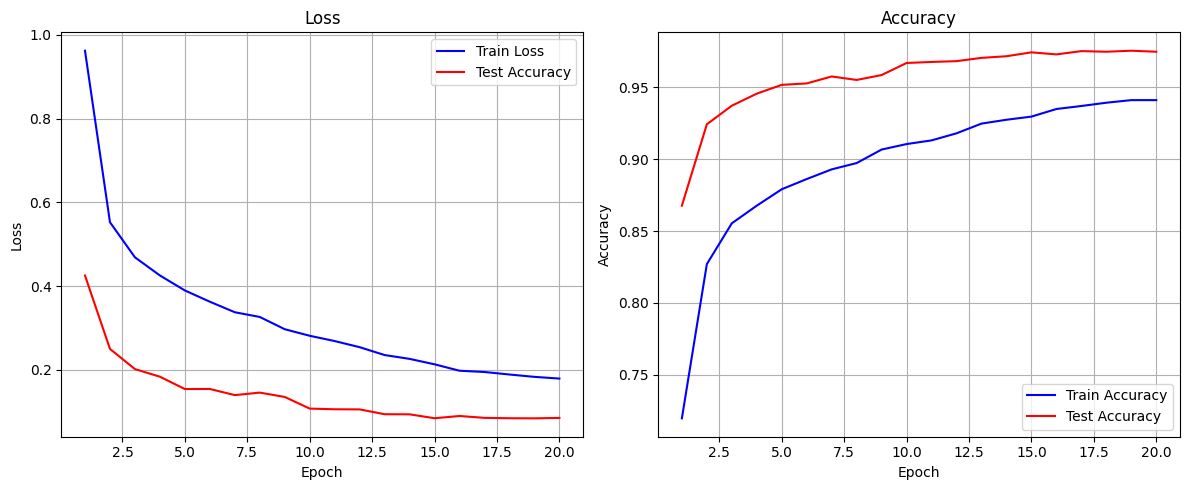

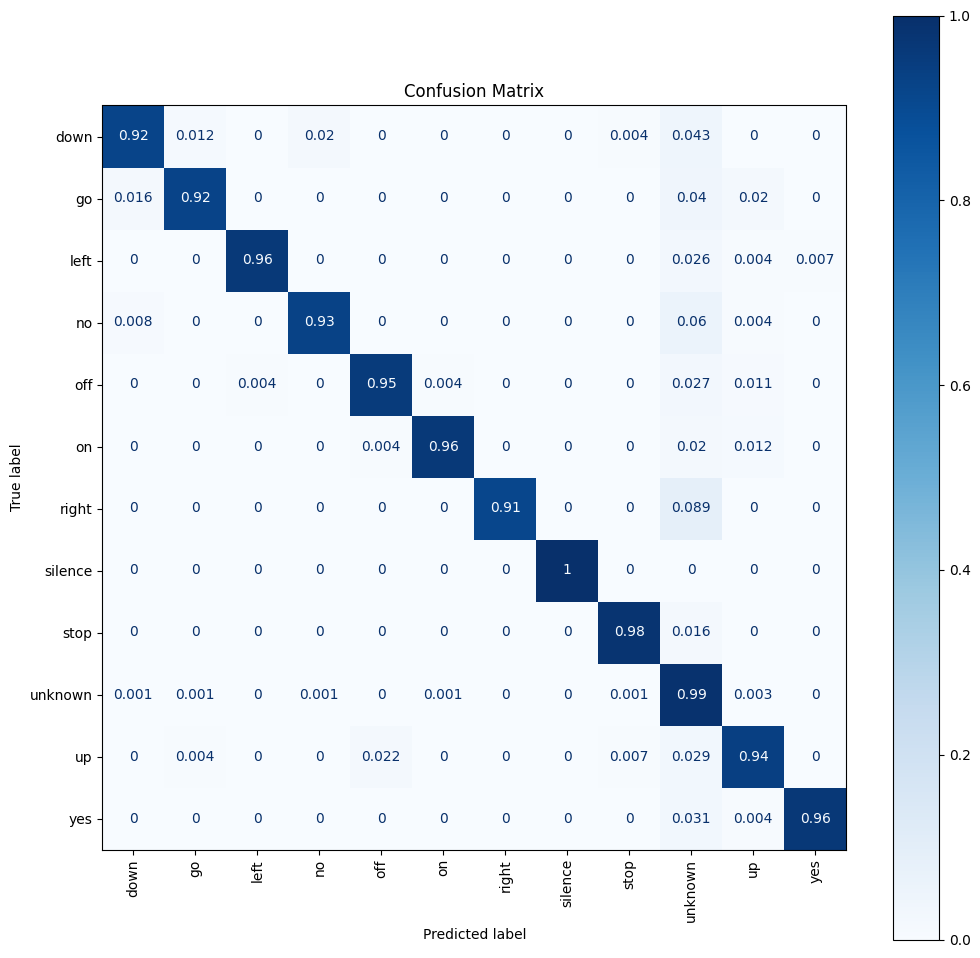

<module 'matplotlib.pyplot' from '/home/aaa/Desktop/deep_learning/ConvolutionalNeuralNeutworks/Transformers/transformer_venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [5]:
plot_loss_and_accuracy(
    train_losses, test_losses, train_accuracies, test_accuracies, num_epochs
)

true_labels, pred_labels = get_all_preds(model, test_loader, device)

plot_confusion_matrix(true_labels, pred_labels, train_dataset, normalize=True)